In [ ]:
print("hello")




hello


In [ ]:
!pip install opencv-python numpy


In [24]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import zipfile


zip_path = r"D:\FracAtlas.zip"

# Step 2: Where to extract
extract_to = r"D:\FracAtlas_extracted"

# Step 3: Extract all files if not already extracted
if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("✅ Files extracted to:", extract_to)
else:
    print("⚠️ Files already extracted at:", extract_to)


✅ Files extracted to: D:\FracAtlas_extracted


In [55]:
# Step 4: Build path to the image you want
image_path = os.path.join(extract_to, "FracAtlas", "images", "Fractured", "IMG0000777.jpg")
print("Looking for:", image_path)

Looking for: D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg


In [56]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

✅ Image loaded. Shape: (454, 373)


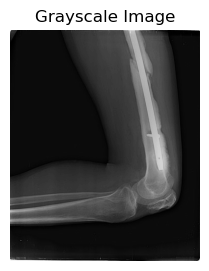

In [104]:
if image is None:
    print("❌ Image not loaded. Check path again.")
else:
    print("✅ Image loaded. Shape:", image.shape)

    # Step 6: Show image
    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap="gray")
    plt.title("Grayscale Image")
    plt.axis("off")
    plt.show()

✅ Image loaded. Shape: (454, 373)


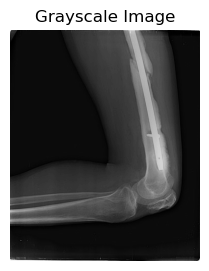

In [103]:
image_path = r"D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg"
image_path

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    print("❌ Image not loaded. Check path again.")
else:
    print("✅ Image loaded. Shape:", image.shape)
    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap="gray")
    plt.title("Grayscale Image")
    plt.axis("off")
    plt.show()

In [88]:
annotation = {
    "id" : 50,
    "iscrowd" : 0,
    #"image_id" : 42,
    "category_id" : 0,
    "segmentation" :[[
          85.40386195562859, 166.75267050123256, 110.39811010682004,
          157.0534100246508, 114.87469186524238, 172.721446179129,
          108.15981922760886, 179.063270336894, 106.29457682826622,
          188.38948233360725, 87.64215283483976, 182.7937551355793
        ]
    ], 
    "bbox" :[
        85.40386195562859, 157.0534100246508, 29.470829909613798,
        31.33607230895646
      ],
    "area": 591.9390435010991
}

curr_h, curr_w = image.shape
orig_w, orig_h = 373, 454  

# --- Step 4: Calculate scaling factors ---
scale_x = curr_w / orig_w
scale_y = curr_h / orig_h
print(f"Scaling factors: X={scale_x:.3f}, Y={scale_y:.3f}")


Scaling factors: X=1.000, Y=1.000


In [89]:
# extract polygon points from annotation
#flattened list of x,y - converts into (x,y) pairs

segmentation = annotation["segmentation"][0]
polygon_points = np.array(segmentation).reshape(-1, 2)
polygon_points = (polygon_points * [scale_x, scale_y]).astype(np.int32)
print("Polygon points:", polygon_points)

Polygon points: [[ 85 166]
 [110 157]
 [114 172]
 [108 179]
 [106 188]
 [ 87 182]]


In [90]:
mask = np.zeros(image.shape, dtype=np.uint8)
print(mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [91]:
cv2.fillPoly(mask, [polygon_points], color= 255)

x, y, w, h = annotation["bbox"]
x1 = int(x * scale_x)
y1 = int(y * scale_y)
x2 = int((x + w) * scale_x)
y2 = int((y + h) * scale_y)

image_with_bbox = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.rectangle(image_with_bbox, (x1, y1), (x2, y2), (0, 255, 0), 2)


overlay = cv2.addWeighted(image, 0.7, mask, 0.3, 0)
print(overlay)

[[162 160  90 ... 153 162 160]
 [162  93  28 ...   4   8 137]
 [155  27  18 ...   0   4   0]
 ...
 [163 147 150 ...  10  41 163]
 [160 164 164 ...  54 152 162]
 [163 164 155 ... 164 159 161]]


In [92]:
plt.figure(figsize=(18,6))


<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

(-0.5, 372.5, 453.5, -0.5)

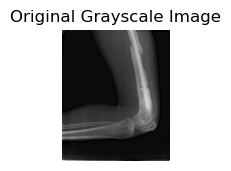

In [93]:
plt.subplot(1,4,1) #original image
plt.imshow(image, cmap='gray')
plt.title("Original Grayscale Image") 
plt.axis("off")

(-0.5, 372.5, 453.5, -0.5)

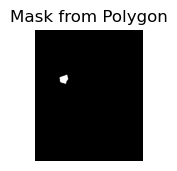

In [94]:
 # Mask
plt.subplot(1,4,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask from Polygon")
plt.axis("off")

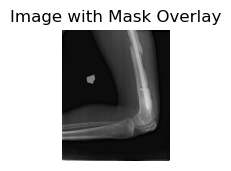

In [95]:
# image + mask overlay
plt.subplot(1,4,3)
plt.imshow(overlay, cmap='gray')
plt.title("Image with Mask Overlay")
plt.axis("off")
plt.show()

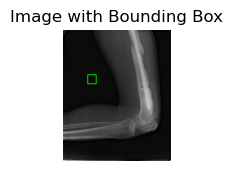

In [96]:
#bounding box overlay
plt.subplot(1,4,4)
plt.imshow(image_with_bbox)
plt.title("Image with Bounding Box")    
plt.axis("off")
plt.show()

[INFO] Loaded image size (HxW): 454 x 373
[INFO] Scale factors -> x: 1.0000, y: 1.0000
[DEBUG] Polygon bbox (from points): x[85-115], y[157-188]
[DEBUG] Annotation bbox scaled    : x[85-115], y[157-188]
[DEBUG] IoU(poly_bbox, ann_bbox): 1.0000


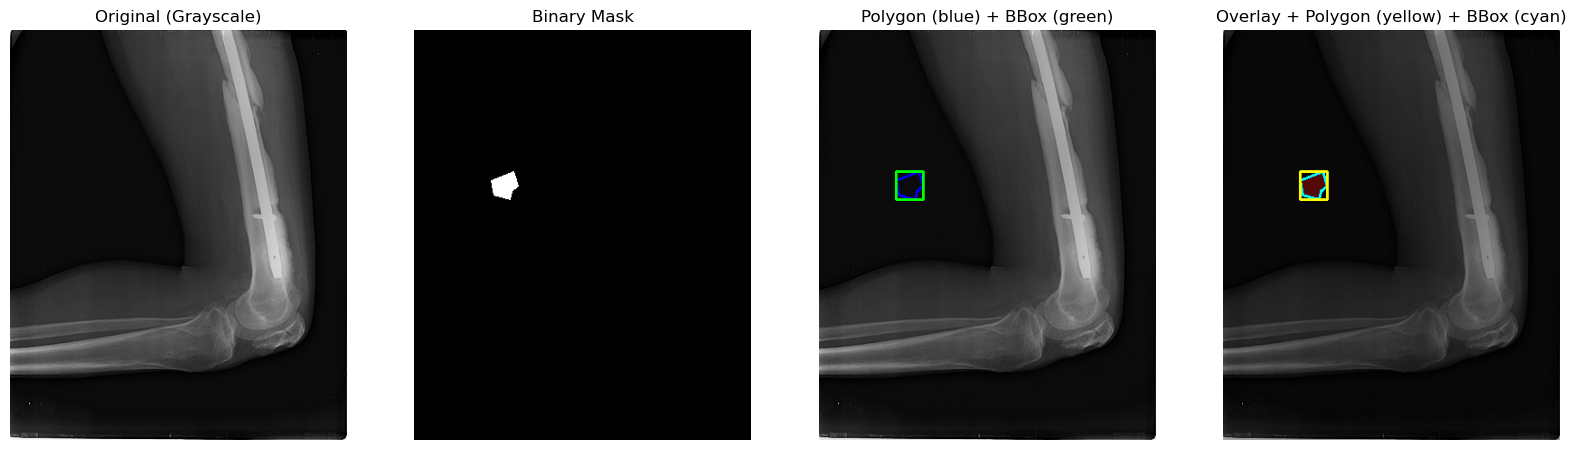

In [101]:
# ===== Imports =====
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ===== Inputs =====
image_path = r"D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg"

# Your annotation dict (example you provided)
annotation = {
    "id": 50,
    "iscrowd": 0,
    "image_id": 42,
    "category_id": 0,
    "segmentation": [[
        85.40386195562859, 166.75267050123256,
        110.39811010682004, 157.0534100246508,
        114.87469186524238, 172.721446179129,
        108.15981922760886, 179.063270336894,
        106.29457682826622, 188.38948233360725,
        87.64215283483976, 182.7937551355793
    ]],
    "bbox": [
        85.40386195562859, 157.0534100246508,
        29.470829909613798, 31.33607230895646
    ],
    "area": 591.9390435010991
}

# If you KNOW the original (annotation) size, put it here.
# If unknown, set to None and we'll assume no scaling.
orig_size = None  # e.g., set to (1024, 1024) if annotations were made on 1024x1024 images

# ===== Load image (grayscale) =====
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Could not load image at: {image_path}")
curr_h, curr_w = image.shape[:2]
print(f"[INFO] Loaded image size (HxW): {curr_h} x {curr_w}")

# ===== Determine scaling =====
if orig_size is None:
    # Assume annotation coordinates already match this image's size
    orig_w, orig_h = curr_w, curr_h
else:
    orig_w, orig_h = orig_size

scale_x = curr_w / float(orig_w)
scale_y = curr_h / float(orig_h)
print(f"[INFO] Scale factors -> x: {scale_x:.4f}, y: {scale_y:.4f}")

# ===== Prepare polygon points =====
seg_list = annotation["segmentation"][0]  # first polygon; loop if more
poly = np.array(seg_list, dtype=np.float32).reshape(-1, 2)  # [[x1,y1],[x2,y2],...]
poly_scaled = poly * np.array([scale_x, scale_y], dtype=np.float32)

# Clip to valid pixel range to avoid drawing outside image
poly_scaled[:, 0] = np.clip(poly_scaled[:, 0], 0, curr_w - 1)
poly_scaled[:, 1] = np.clip(poly_scaled[:, 1], 0, curr_h - 1)
poly_int = np.rint(poly_scaled).astype(np.int32)  # round to nearest int

# ===== Create mask from polygon =====
mask = np.zeros((curr_h, curr_w), dtype=np.uint8)
if len(poly_int) >= 3:  # need at least 3 points to make a polygon
    cv2.fillPoly(mask, [poly_int], color=255)
else:
    print("[WARN] Polygon has fewer than 3 points; cannot fill mask.")

# ===== Scale & draw bounding box =====
x, y, w, h = annotation["bbox"]
x1 = int(round(x * scale_x))
y1 = int(round(y * scale_y))
x2 = int(round((x + w) * scale_x))
y2 = int(round((y + h) * scale_y))

# Clip bbox to image bounds
x1 = np.clip(x1, 0, curr_w - 1)
y1 = np.clip(y1, 0, curr_h - 1)
x2 = np.clip(x2, 0, curr_w - 1)
y2 = np.clip(y2, 0, curr_h - 1)

# For visualization with color drawings, convert gray->BGR
img_draw = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw polygon outline (blue) to confirm placement
if len(poly_int) >= 2:
    cv2.polylines(img_draw, [poly_int], isClosed=True, color=(255, 0, 0), thickness=2)

# Draw bounding box (green)
cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)

# ===== Overlay mask on grayscale (red tint) =====
# Make a red overlay from the mask
overlay_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
red = np.zeros_like(overlay_color)
red[:, :, 2] = mask  # put mask in red channel
alpha_img, alpha_mask = 0.7, 0.3
overlay = cv2.addWeighted(overlay_color, alpha_img, red, alpha_mask, 0)

# Also draw bbox & polygon on the overlay for a single view
overlay_draw = overlay.copy()
if len(poly_int) >= 2:
    cv2.polylines(overlay_draw, [poly_int], isClosed=True, color=(255, 255, 0), thickness=2)  # yellow polygon
cv2.rectangle(overlay_draw, (x1, y1), (x2, y2), (0, 255, 255), thickness=2)  # cyan bbox

# ===== Debug prints to verify alignment =====
px_min, py_min = poly_int.min(axis=0)
px_max, py_max = poly_int.max(axis=0)
print(f"[DEBUG] Polygon bbox (from points): x[{px_min}-{px_max}], y[{py_min}-{py_max}]")
print(f"[DEBUG] Annotation bbox scaled    : x[{x1}-{x2}], y[{y1}-{y2}]")

# IoU between polygon bbox and annotation bbox (rough sanity check)
def iou_from_boxes(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    inter_x1 = max(ax1, bx1); inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2); inter_y2 = min(ay2, by2)
    inter_w = max(0, inter_x2 - inter_x1 + 1)
    inter_h = max(0, inter_y2 - inter_y1 + 1)
    inter = inter_w * inter_h
    area_a = max(0, ax2 - ax1 + 1) * max(0, ay2 - ay1 + 1)
    area_b = max(0, bx2 - bx1 + 1) * max(0, by2 - by1 + 1)
    denom = area_a + area_b - inter
    return inter / denom if denom > 0 else 0.0

poly_box = (int(px_min), int(py_min), int(px_max), int(py_max))
ann_box  = (x1, y1, x2, y2)
print(f"[DEBUG] IoU(poly_bbox, ann_bbox): {iou_from_boxes(poly_box, ann_box):.4f}")

# ===== Show results =====
plt.figure(figsize=(20,6))

plt.subplot(1,4,1)
plt.imshow(image, cmap="gray")
plt.title("Original (Grayscale)")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask, cmap="gray")
plt.title("Binary Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.title("Polygon (blue) + BBox (green)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(overlay_draw, cv2.COLOR_BGR2RGB))
plt.title("Overlay + Polygon (yellow) + BBox (cyan)")
plt.axis("off")

plt.show()


✅ Image loaded. Shape: (454, 373)
✅ Cropped image shape: (453, 372)


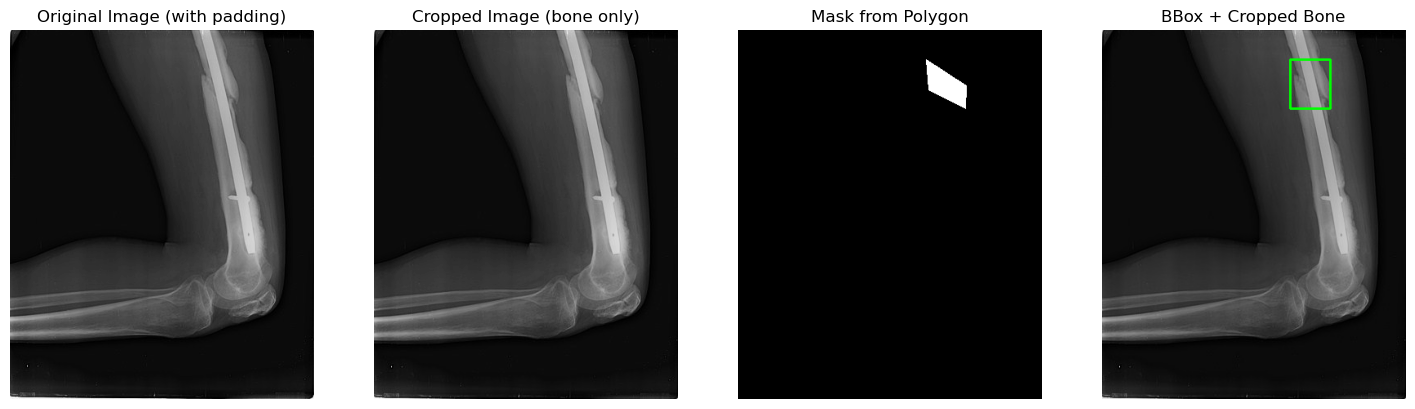

In [110]:
# --- Import required libraries ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Load your grayscale image ---
image_path = r"D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print("❌ Image not loaded. Please check the path again.")
    exit()

print("✅ Image loaded. Shape:", image.shape)

# --- Step 2: Example Annotation Dictionary (update with your JSON values) ---
annotation = {
    "id": 59,
      "iscrowd": 0,
      "image_id": 50,
      "category_id": 0,
      "segmentation": [
        [
          234.2502054231717, 74.60969597370584, 279.01602300739523,
          98.11175020542318, 280.1351684470008, 69.38701725554643,
          231.26581758422347, 37.67789646672145
        ]
      ],
      "bbox": [
        231.26581758422347, 37.67789646672145, 48.86935086277734,
        60.43385373870173
      ],
      "area": 1511.1945629195825
}

# Assume original dataset size (from JSON metadata, adjust if available)
# If your JSON has "height" and "width", replace here
orig_h, orig_w = image.shape[0], image.shape[1]  

# --- Step 3: Auto-crop black padding ---
coords = np.argwhere(image > 0)  # find non-black pixels
y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)
cropped = image[y_min:y_max, x_min:x_max]

print("✅ Cropped image shape:", cropped.shape)

# --- Step 4: Scale segmentation points ---
segmentation = np.array(annotation["segmentation"][0]).reshape(-1, 2)

scale_x = cropped.shape[1] / orig_w
scale_y = cropped.shape[0] / orig_h

polygon_points = np.array([ [int(x * scale_x) - x_min, int(y * scale_y) - y_min] for x, y in segmentation
], dtype=np.int32)

# --- Step 5: Create mask ---
mask = np.zeros(cropped.shape, dtype=np.uint8)
cv2.fillPoly(mask, [polygon_points], color=255)

# --- Step 6: Extract bounding box & scale ---
x, y, w, h = annotation["bbox"]
x1 = int(x * scale_x) - x_min
y1 = int(y * scale_y) - y_min
x2 = int((x + w) * scale_x) - x_min
y2 = int((y + h) * scale_y) - y_min

# --- Step 7: Draw bounding box ---
image_with_bbox = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)
cv2.rectangle(image_with_bbox, (x1, y1), (x2, y2), (0,255,0), 2)

# --- Step 8: Overlay mask on cropped image ---
overlay = cv2.addWeighted(cropped, 0.7, mask, 0.3, 0)

# --- Step 9: Show results ---
plt.figure(figsize=(18,6))

# Original
plt.subplot(1,4,1)
plt.imshow(image, cmap="gray")
plt.title("Original Image (with padding)")
plt.axis("off")

# Cropped
plt.subplot(1,4,2)
plt.imshow(cropped, cmap="gray")
plt.title("Cropped Image (bone only)")
plt.axis("off")

# Mask
plt.subplot(1,4,3)
plt.imshow(mask, cmap="gray")
plt.title("Mask from Polygon")
plt.axis("off")

# Bounding Box + Mask
plt.subplot(1,4,4)
plt.imshow(image_with_bbox)
plt.title("BBox + Cropped Bone")
plt.axis("off")

plt.show()


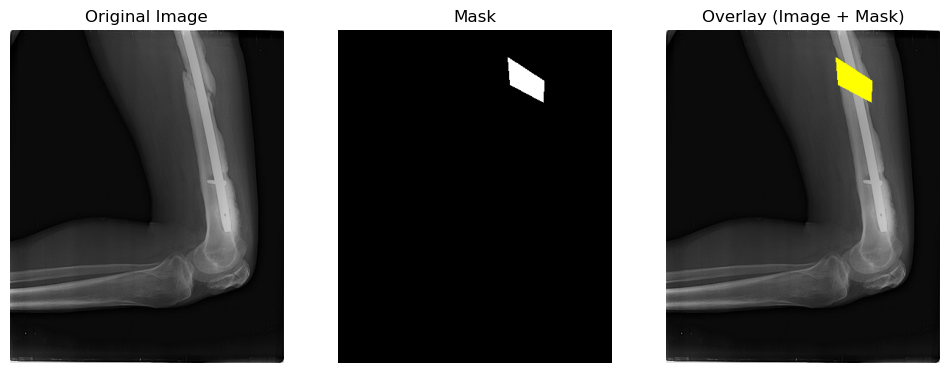

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- Your annotation data ----
annotation = {
   "id": 59,
      "iscrowd": 0,
      "image_id": 50,
      "category_id": 0,
      "segmentation": [
        [
          234.2502054231717, 74.60969597370584, 279.01602300739523,
          98.11175020542318, 280.1351684470008, 69.38701725554643,
          231.26581758422347, 37.67789646672145
        ]
      ],
      "bbox": [
        231.26581758422347, 37.67789646672145, 48.86935086277734,
        60.43385373870173
      ],
      "area": 1511.1945629195825
}

# ---- Load the actual image ----
image_path = r"D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert BGR→RGB for matplotlib
height, width = image.shape[:2]

# ---- Create empty mask ----
mask = np.zeros((height, width), dtype=np.uint8)

# ---- Draw polygon from segmentation ----
for seg in annotation["segmentation"]:
    points = np.array(seg).reshape((-1, 2)).astype(np.int32)
    cv2.fillPoly(mask, [points], 1)

# ---- Show outputs (inline only) ----
plt.figure(figsize=(12,6))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Mask only
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

# Overlay (image + mask in red)
overlay = image.copy()
overlay[mask == 1] = [255, 255, 0]  
plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay (Image + Mask)")
plt.axis("off")

plt.show()
